### Load dataset from tfds

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

ds, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSXQCZ1/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSXQCZ1/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSXQCZ1/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


### Load training data



In [ ]:
def values_to_bins(data, start, stop, level):
  bins = np.linspace(start, stop, level)
  data_processed = np.digitize(data, bins) - 1
  return data_processed

def one_hot_encoding(data, cat_num):
  return np.eye(cat_num)[data]

def label_norm(data, start, stop, level):
  data_processed = values_to_bins(data, start, stop, level)
  data_processed = one_hot_encoding(data_processed, level)
  return data_processed
  
START = 0
STOP = 1
LEVEL = 4

In [ ]:
train_data = ds['train']

x_train = []
y_train = []
for text, label in train_data:
  x_train.append(str(text.numpy().decode('utf-8')))
  y_train.append(label.numpy())

y_train = np.array(y_train)

In [ ]:
val_data = ds['test']

x_val = []
y_val = []
for text, label in val_data:
  x_val.append(str(text.numpy().decode('utf-8')))
  y_val.append(label.numpy())

y_val = np.array(y_val)

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

25000
25000
25000
25000


In [ ]:
x = x_train + x_val
y = y_train + y_val

In [ ]:
import random

train_indices = random.sample(range(50000), 25000)
val_indices = [i for i in range(50000) if i not in train_indices]

x_train = [x[i] for i in train_indices]
y_train = [y[i] for i in train_indices]
x_val = [x[i] for i in val_indices]
y_val = [y[i] for i in val_indices]

### Text preprocessing

In [ ]:
import nltk
import re
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
def denoise(text):
  text = re.sub(r"http\S+", '<LINK>', text)
  text = re.sub(r"<.*?>",' ', text)
  return text

def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  word_tokens = text.split()
  return ' '.join([w for w in word_tokens if w not in stop_words])

def remove_numbers(text):
  return re.sub('\d+', '', text)

def remove_punctuations(text):
  table = str.maketrans('', '', string.punctuation)  
  word_tokens = text.split()
  return ' '.join([w.translate(table) for w in word_tokens])

def remove_space(text):
  text = re.sub('\s+', ' ', text)
  word_tokens = text.split()
  return ' '.join(word_tokens)

def stemming(text):
 ps = PorterStemmer()
 word_tokens = word_tokenize(text)
 return ' '.join([ps.stem(w) for w in word_tokens])

def lemmatize(text):
  wl = WordNetLemmatizer()
  word_tokens = text.split()
  return ' '.join([wl.lemmatize(w, pos="v") for w in word_tokens])

def normalize(text):
  text = denoise(text)
  text = remove_numbers(text)
  text = remove_punctuations(text)
  text = remove_space(text)
  #text = stemming(text)
  text = lemmatize(text)
  #text = remove_stopwords(text)
  return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
x_train_processed = list(map(lambda x:normalize(x), x_train))

In [ ]:
x_val_processed = list(map(lambda x:normalize(x), x_val))

In [ ]:
x_train[:20]

['I have read the last comment made on this film and have to utterly and totally disagree with it.<br /><br />You see, I am of Portuguese nationality and even though this film may say little to someone coming from Boston, it surely says something to both Portuguese and Brazilian people, as well as immigrants everywhere.<br /><br />And why, you may wonder? Well, firstly, this film deals with two sibling nations: Portugal and Brazil. Brazil gained its independence in the early 19th century (by the hands of the heir to the Portuguese throne)and since then relations improved greatly. <br /><br />However, meaningful as this may be, there is still a lot of prejudice. Because of the economic climate in Brazil during the 1990\'s, immigration to Portugal grew massively. You see, Portugal is not only a country sharing a similar language, culture and beliefs as Brazil but is also a gateway to the rest of Europe. Some people were thus forced to make the decision to cross the Atlantic and look for 

In [ ]:
x_train_processed[:20]

['I have read the last comment make on this film and have to utterly and totally disagree with it You see I be of Portuguese nationality and even though this film may say little to someone come from Boston it surely say something to both Portuguese and Brazilian people as well as immigrants everywhere And why you may wonder Well firstly this film deal with two sibling nations Portugal and Brazil Brazil gain its independence in the early th century by the hand of the heir to the Portuguese throneand since then relations improve greatly However meaningful as this may be there be still a lot of prejudice Because of the economic climate in Brazil during the s immigration to Portugal grow massively You see Portugal be not only a country share a similar language culture and beliefs as Brazil but be also a gateway to the rest of Europe Some people be thus force to make the decision to cross the Atlantic and look for a better life and Portugal be the first logical place to try to immigrate to 

### Tokenizing the sentences

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 10000
embedding_dim = 16
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train_processed)

In [ ]:
total_words = len(tokenizer.word_index) + 1
print(tokenizer.num_words)
print(len(tokenizer.word_index))

10000
102447


### Transfer senteces to sequences and padding

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 120
trunc_type = 'post'
padding_type = 'post'

sequences = tokenizer.texts_to_sequences(x_train_processed)
training_padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [ ]:
sequences = tokenizer.texts_to_sequences(x_val_processed)
val_padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [ ]:
training_padded[:20].shape

(20, 120)

### Build a reverse word index

In [ ]:
reverse_word_index = dict([value, key] for key, value in tokenizer.word_index.items())

In [ ]:
def decode_comments(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

for i in range(50):
  print(i, ': ')
  print(decode_comments(val_padded[i]))
  print(x_val[i])

print(val_padded.shape)

0 : 


NameError: ignored

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((training_padded, y_train))
train_data = train_data.shuffle(buffer_size=1024).batch(32)

In [ ]:
val_data = tf.data.Dataset.from_tensor_slices((val_padded, y_val))
val_data = val_data.shuffle(buffer_size=1024).batch(32)

### Simple fully connected layers

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(training_padded, y_train, verbose=1, validation_data=(val_padded, y_val), epochs=30)

Epoch 1/30
782/782 [==============================] - 6s 8ms/step - loss: 0.6902 - accuracy: 0.5845 - val_loss: 0.6868 - val_accuracy: 0.6369
Epoch 2/30
782/782 [==============================] - 6s 8ms/step - loss: 0.6816 - accuracy: 0.6464 - val_loss: 0.6759 - val_accuracy: 0.6557
Epoch 3/30
782/782 [==============================] - 6s 8ms/step - loss: 0.6676 - accuracy: 0.6754 - val_loss: 0.6600 - val_accuracy: 0.6876
Epoch 4/30
782/782 [==============================] - 6s 8ms/step - loss: 0.6484 - accuracy: 0.7076 - val_loss: 0.6393 - val_accuracy: 0.7117
Epoch 5/30
782/782 [==============================] - 6s 8ms/step - loss: 0.6244 - accuracy: 0.7362 - val_loss: 0.6150 - val_accuracy: 0.7367
Epoch 6/30
782/782 [==============================] - 7s 8ms/step - loss: 0.5973 - accuracy: 0.7611 - val_loss: 0.5885 - val_accuracy: 0.7638
Epoch 7/30
782/782 [==============================] - 7s 9ms/step - loss: 0.5681 - accuracy: 0.7848 - val_loss: 0.5605 - val_accuracy: 0.7782
Epoch 

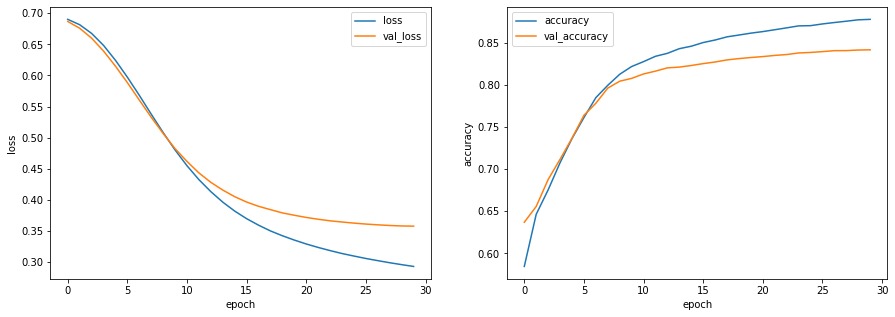

In [ ]:
% matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)

plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
plt.legend()

### Conv1D + Dense layers

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Conv1D(128, 5, activation='relu'),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(training_padded, y_train, verbose=1, validation_data=(val_padded, y_val), epochs=20)

Epoch 1/20
782/782 [==============================] - 8s 10ms/step - loss: 0.6871 - accuracy: 0.6160 - val_loss: 0.6692 - val_accuracy: 0.7007
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 0.6183 - accuracy: 0.7462 - val_loss: 0.5609 - val_accuracy: 0.7768
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 0.4925 - accuracy: 0.8057 - val_loss: 0.4540 - val_accuracy: 0.8075
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 0.4021 - accuracy: 0.8328 - val_loss: 0.4038 - val_accuracy: 0.8198
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 0.3576 - accuracy: 0.8492 - val_loss: 0.3810 - val_accuracy: 0.8292
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 0.3327 - accuracy: 0.8589 - val_loss: 0.3764 - val_accuracy: 0.8329
Epoch 7/20
782/782 [==============================] - 8s 10ms/step - loss: 0.3160 - accuracy: 0.8677 - val_loss: 0.3645 - val_accuracy: 0.8370

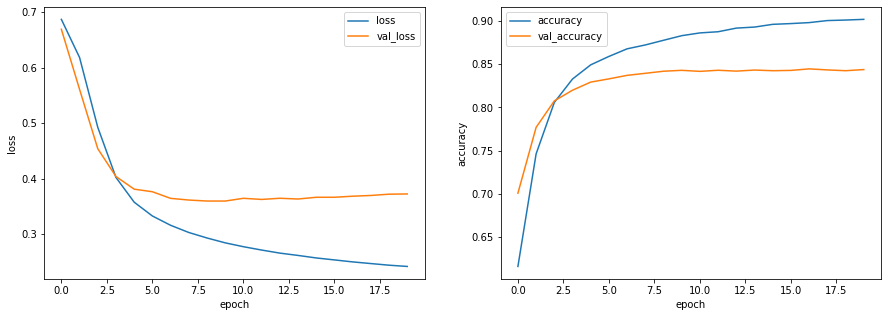

In [ ]:
% matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)

plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
plt.legend()

### Build LSTM model

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             #tf.keras.layers.GlobalAveragePooling1D(),
                             #tf.keras.layers.Dropout(0.2),
                             #tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 202,253
Trainable params: 202,253
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(training_padded, y_train, verbose=1, validation_data=(val_padded, y_val), epochs=20)

Epoch 1/20
782/782 [==============================] - 53s 68ms/step - loss: 0.6675 - accuracy: 0.5796 - val_loss: 0.6265 - val_accuracy: 0.6536
Epoch 2/20
782/782 [==============================] - 52s 66ms/step - loss: 0.4958 - accuracy: 0.7646 - val_loss: 0.4506 - val_accuracy: 0.7975
Epoch 3/20
782/782 [==============================] - 51s 65ms/step - loss: 0.3949 - accuracy: 0.8306 - val_loss: 0.4004 - val_accuracy: 0.8258
Epoch 4/20
782/782 [==============================] - 52s 66ms/step - loss: 0.3445 - accuracy: 0.8555 - val_loss: 0.3901 - val_accuracy: 0.8289
Epoch 5/20
782/782 [==============================] - 52s 66ms/step - loss: 0.3195 - accuracy: 0.8667 - val_loss: 0.3755 - val_accuracy: 0.8381
Epoch 6/20
782/782 [==============================] - 51s 65ms/step - loss: 0.3005 - accuracy: 0.8745 - val_loss: 0.3757 - val_accuracy: 0.8350
Epoch 7/20
782/782 [==============================] - 51s 65ms/step - loss: 0.2873 - accuracy: 0.8805 - val_loss: 0.3820 - val_accuracy:

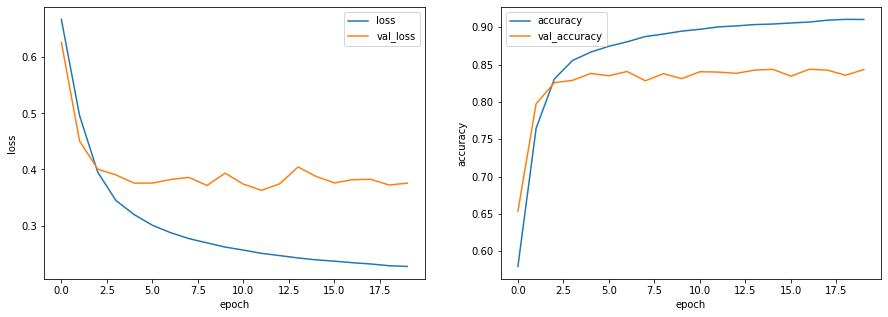

In [ ]:
% matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)

plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
plt.legend()


### Build GRU model

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               31488     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 192,269
Trainable params: 192,269
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(training_padded, y_train, verbose=1, validation_data=(val_padded, y_val), epochs=20)

Epoch 1/20
782/782 [==============================] - 52s 67ms/step - loss: 0.6929 - accuracy: 0.5113 - val_loss: 0.6920 - val_accuracy: 0.5175
Epoch 2/20
782/782 [==============================] - 51s 65ms/step - loss: 0.6504 - accuracy: 0.6283 - val_loss: 0.5807 - val_accuracy: 0.7616
Epoch 3/20
782/782 [==============================] - 51s 65ms/step - loss: 0.4760 - accuracy: 0.7887 - val_loss: 0.4718 - val_accuracy: 0.7915
Epoch 4/20
782/782 [==============================] - 51s 65ms/step - loss: 0.3931 - accuracy: 0.8292 - val_loss: 0.4822 - val_accuracy: 0.7543
Epoch 5/20
782/782 [==============================] - 51s 65ms/step - loss: 0.3503 - accuracy: 0.8522 - val_loss: 0.3861 - val_accuracy: 0.8238
Epoch 6/20
782/782 [==============================] - 51s 65ms/step - loss: 0.3248 - accuracy: 0.8661 - val_loss: 0.3681 - val_accuracy: 0.8364
Epoch 7/20
782/782 [==============================] - 52s 66ms/step - loss: 0.3057 - accuracy: 0.8745 - val_loss: 0.3668 - val_accuracy:

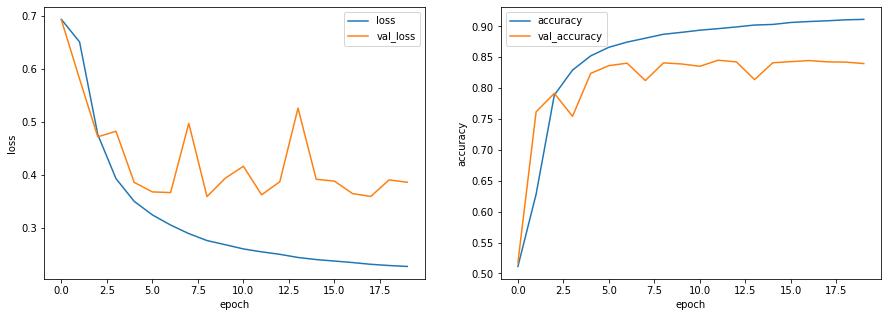

In [ ]:
% matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)

plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
plt.legend()